# Image and Text Analysis using Multi-modal Embeddings

Author: Justin Chun-ting Ho

Last Update: 19 Jan 2024

Description: Workshop materials for the Image and Text Analysis using Multi-modal Embeddings (Edinburgh Centre for Data, Culture & Society). Designed to work with Google Colab.


## Setting Up

In [1]:
!pip install bertopic
import os
import glob
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.8 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039281 sha256=f4dbde6cbc58eb79accfc9119d420773075f8d94eb8433bc43c1f621e5cb83be
  Stored in di

## Getting Data

In [2]:
import urllib
import zipfile
zip_path, _ = urllib.request.urlretrieve("https://github.com/justinchuntingho/ImageTextAnalysisWorkshop/raw/main/data.zip")
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall("./")

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df

,image_path,shortcode,text
0,data/Cz4KVwfMlQ1_5.jpg,Cz4KVwfMlQ1,Looking for the perfect graduation gift? Our r...
1,data/C1zTaHesEEC_3.jpg,C1zTaHesEEC,2024 is off to a great start already 🎊 For tho...
2,data/C2SCps9MpFm_5.jpg,C2SCps9MpFm,Missed our Activities Fair? There's still a ch...
3,data/Czyc1E-u_Xi_3.jpg,Czyc1E-u_Xi,Continue the celebration of our international ...
4,data/C1e5C4mOM3Q.jpg,C1e5C4mOM3Q,Starting your studies with us in January? Have...
...,...,...,...
207,data/Cy_ag2ZoZjJ.jpg,Cy_ag2ZoZjJ,Don’t worry if you weren’t able to make it to ...
208,data/CzqZ175O8sN_3.jpg,CzqZ175O8sN,Attention all Alumni and soon-to-be-Alumni Win...
209,data/C1FP90gMw8E.jpg,C1FP90gMw8E,⚠️ Final reminder: the University closes tomor...
210,data/Cy71x8WO5FA_3.jpg,Cy71x8WO5FA,Good morning to everyone attending our Undergr...


# Model Training

## True MultiModal

In [5]:
from PIL import Image
import base64
from io import BytesIO
from IPython.display import HTML

def get_concat_h_multi_resize(im_list, resample=Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                      for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

def get_concat_v_multi_resize(im_list, resample=Image.BICUBIC):
    min_width = min(im.width for im in im_list)
    im_list_resize = [im.resize((min_width, int(im.height * min_width / im.width)),resample=resample)
                      for im in im_list]
    total_height = sum(im.height for im in im_list_resize)
    dst = Image.new('RGB', (min_width, total_height))
    pos_y = 0
    for im in im_list_resize:
        dst.paste(im, (0, pos_y))
        pos_y += im.height
    return dst

def get_concat_tile_resize(im_list_2d, resample=Image.BICUBIC):
    im_list_v = [get_concat_h_multi_resize(im_list_h, resample=resample) for im_list_h in im_list_2d]
    return get_concat_v_multi_resize(im_list_v, resample=resample)

def get_top_imgs(topic):
    top_imgs = probs_df[topic].nlargest(9).index
    im1 = Image.open(df['image_path'][top_imgs[0]])
    im2 = Image.open(df['image_path'][top_imgs[1]])
    im3 = Image.open(df['image_path'][top_imgs[2]])
    im4 = Image.open(df['image_path'][top_imgs[3]])
    im5 = Image.open(df['image_path'][top_imgs[4]])
    im6 = Image.open(df['image_path'][top_imgs[5]])
    im7 = Image.open(df['image_path'][top_imgs[6]])
    im8 = Image.open(df['image_path'][top_imgs[7]])
    im9 = Image.open(df['image_path'][top_imgs[8]])
    return get_concat_tile_resize([[im1, im2, im3],
                                    [im4, im5, im6],
                                    [im7, im8, im9]])

def image_base64(im):
    with BytesIO() as buffer:
        im.resize((600,600)).save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def truncate_sentence(sentence, tokenizer):
    cur_sentence = sentence
    tokens = tokenizer.encode(cur_sentence)
    if len(tokens) > 77:
        truncated_tokens = tokens[1:76]
        cur_sentence = tokenizer.decode(truncated_tokens)
        return truncate_sentence(cur_sentence, tokenizer)
    else:
        return cur_sentence

In [6]:
from bertopic.backend import MultiModalBackend
from transformers import CLIPTokenizer
model = MultiModalBackend('clip-ViT-B-32', batch_size=32)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

docs = [truncate_sentence(x,tokenizer) for x in df['text'].tolist()]
images = df['image_path'].tolist()

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (122 > 77). Running this sequence through the model will result in indexing errors


In [7]:
docs[0:6]

["looking for the perfect graduation gift? our range of graduation gifts are a great way to commemorate your time at the university. tap our link in bio to see @ uofe _ shop's graduation gifts! pictured : 1. embroidered alumni sweatshirt 2. enamel cufflinks 3. graduation edinbear 4. graduate scarf ( msc ) and degree pin ( bsc / msc ) 5. jennifer court",
 '2 0 2 4 is off to a great start already 🎊 for those who welcomed in the new year here in edinburgh, we hope you enjoyed the twinkly lights, magic and merriment our city has to offer during the festive season ( and all other seasons, too ). here are some of our highlights ✨📸 where did you spend your winter break? are you glad to be',
 "missed our activities fair? there's still a chance to get involved in a new or rediscovered hobby with our taster sessions, happening this week and next as part of # giveitagoweek 😋 from from football to bad films and murder mystery to mahjong, there's a student society for everything and more 🤩 find out

In [8]:
images[0:6]

['data/Cz4KVwfMlQ1_5.jpg',
 'data/C1zTaHesEEC_3.jpg',
 'data/C2SCps9MpFm_5.jpg',
 'data/Czyc1E-u_Xi_3.jpg',
 'data/C1e5C4mOM3Q.jpg',
 'data/C1jell1sQAQ.jpg']

In [9]:
# Embed both images and documents, then average them
doc_image_embeddings = model.embed(docs, images)

In [10]:
topic_model = BERTopic(calculate_probabilities=True,
                       n_gram_range=(1,2),
                       min_topic_size=5, # Setting this based on the smallest category in GS
                       verbose=True)

topics, probs = topic_model.fit_transform(docs, doc_image_embeddings)

2024-01-19 15:42:39,279 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-19 15:42:48,235 - BERTopic - Dimensionality - Completed ✓
2024-01-19 15:42:48,237 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-19 15:42:48,257 - BERTopic - Cluster - Completed ✓
2024-01-19 15:42:48,267 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-19 15:42:48,335 - BERTopic - Representation - Completed ✓


In [11]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13,-1_our_so_in_you,"[our, so, in, you, to, your free, day, at, fre...",[good morning to everyone attending our underg...
1,0,35,0_the_edinburghgrad_to_graduations,"[the, edinburghgrad, to, graduations, winter, ...",[Can you believe it's already been a week sinc...
2,1,33,1_to_and_welcome_new,"[to, and, welcome, new, our, in, your, the, ed...",[looking forward to exploring edinburgh as a n...
3,2,18,2_graduation_uofe_ring_gifts,"[graduation, uofe, ring, gifts, msc, graduatio...",[looking for the perfect graduation gift? our ...
4,3,14,3_the_festive_you_the new,"[the, festive, you, the new, here, to, break, ...",[2 0 2 4 is off to a great start already 🎊 for...
5,4,11,4_taster_fair_taster sessions_the taster,"[taster, fair, taster sessions, the taster, mi...",[missed our activities fair? there's still a c...
6,5,11,5_ai_our_entrepreneurship_in,"[ai, our, entrepreneurship, in, and, student, ...",[For Global Entrepreneurship Week we’re sharin...
7,6,10,6_competition_international student_internatio...,"[competition, international student, internati...",[continue the celebration of our international...
8,7,10,7_dash_edinburgh_aged_km,"[dash, edinburgh, aged, km, the toddler, shoes...","[students and staff *, get out your running sh..."
9,8,10,8_your_complete_your university_you,"[your, complete, your university, you, univers...","[new students, listen up 📢 there are six tasks..."


In [12]:
df['topic'] = topics
probs_df = pd.DataFrame(probs)

In [13]:
# Extract dataframe
topic_info = topic_model.get_topic_info().drop("Representative_Docs", axis=1).drop("Name", axis=1).drop(index=0)
topic_info['Visual'] = [get_top_imgs(x) for x in topic_info.Topic]

Topic,Count,Representation,Visual
0,35,"[the, edinburghgrad, to, graduations, winter, our, you, and, in, winter graduations]",
1,33,"[to, and, welcome, new, our, in, your, the, edinburghwelcomeweek, of]",
2,18,"[graduation, uofe, ring, gifts, msc, graduation gifts, our, pictured, the, for]",
3,14,"[the, festive, you, the new, here, to, break, and, in, are]",
4,11,"[taster, fair, taster sessions, the taster, missed, hobby, in, theres, sessions, or]",
5,11,"[ai, our, entrepreneurship, in, and, student, bio, link, how, the]",
6,10,"[competition, international student, international, the, student, is now, now, exhibition the, exhibition, noon on]",
7,10,"[dash, edinburgh, aged, km, the toddler, shoes, to years, staff get, running shoes, those aged]",
8,10,"[your, complete, your university, you, university, up, start your, apply, studies, university card]",
9,9,"[alumni, new range, order, range, to be, be, to, grads were, to introduce, soon to]",

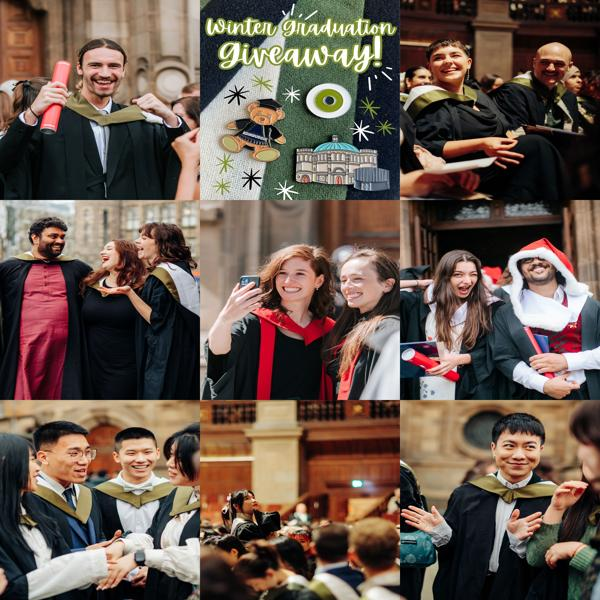
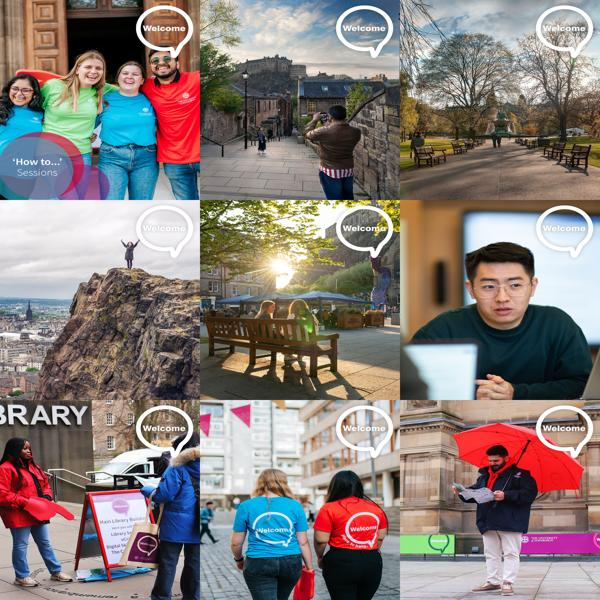
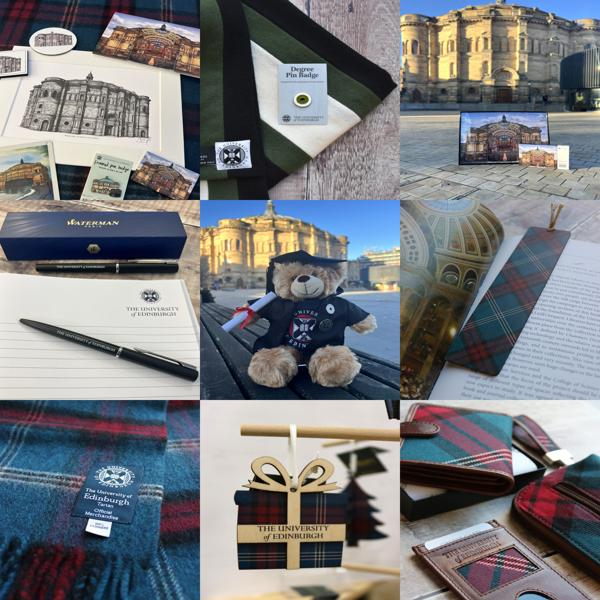
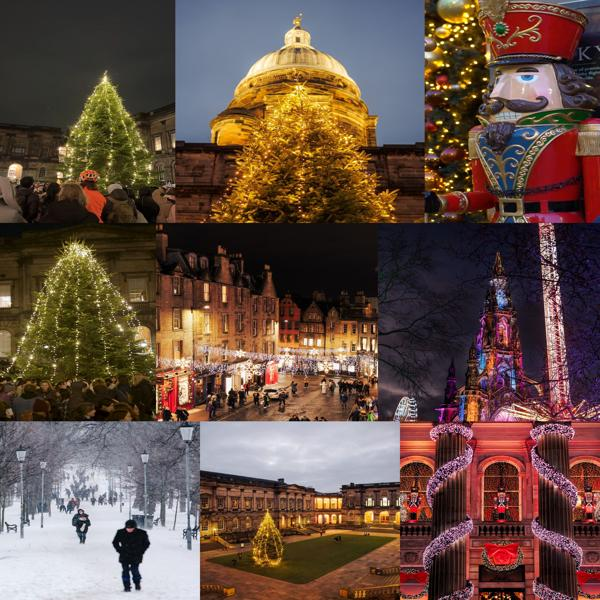
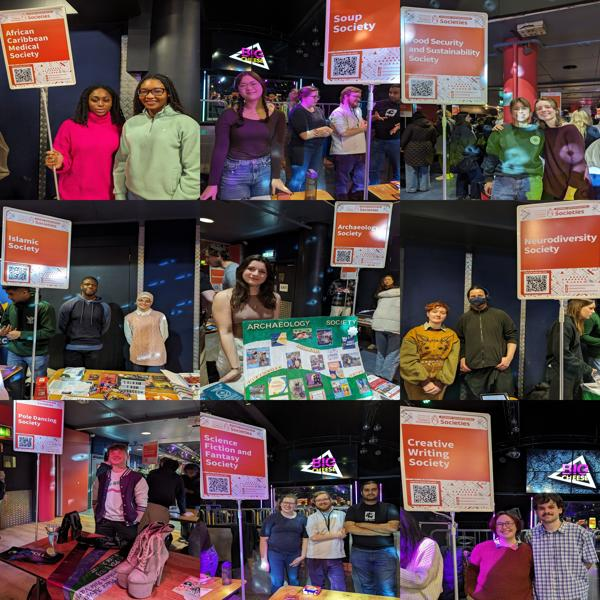
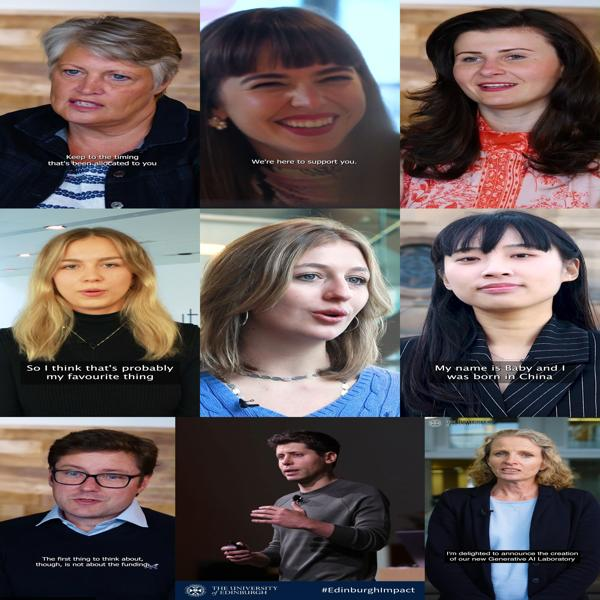
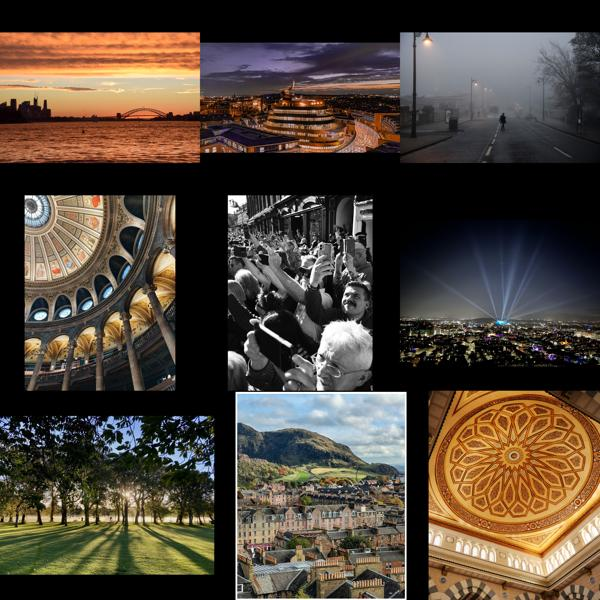
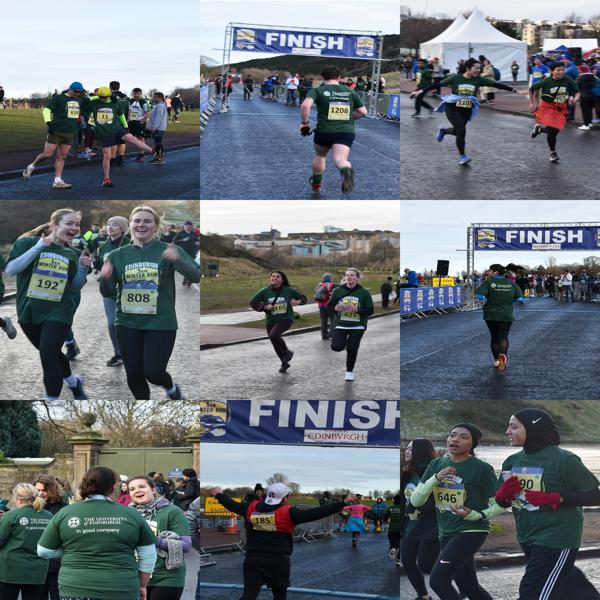
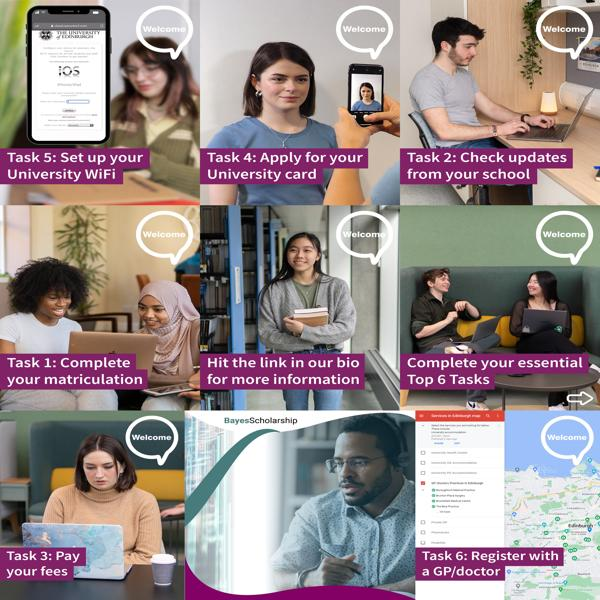
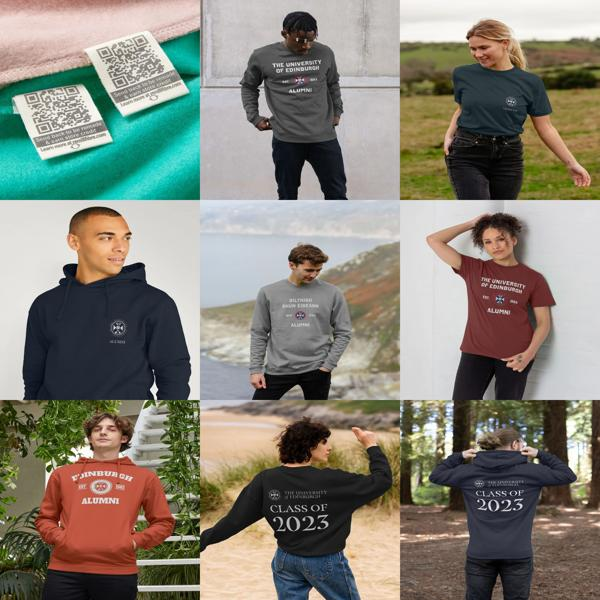
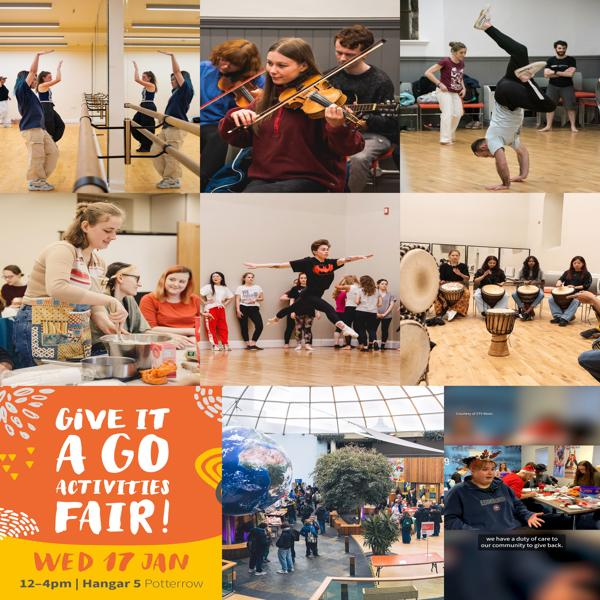
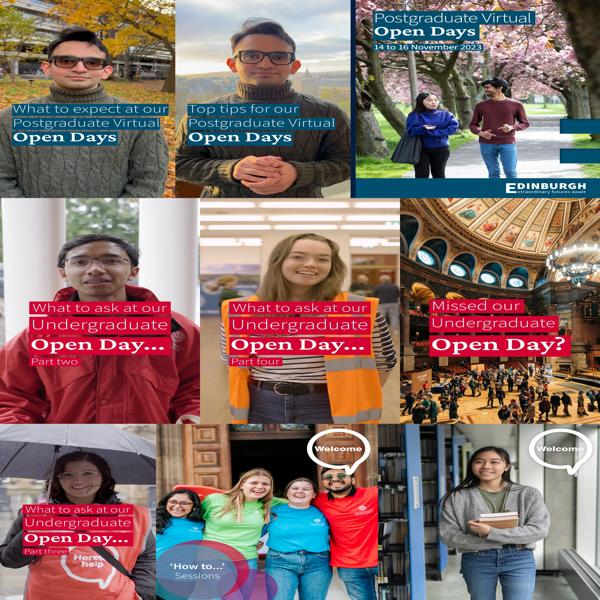
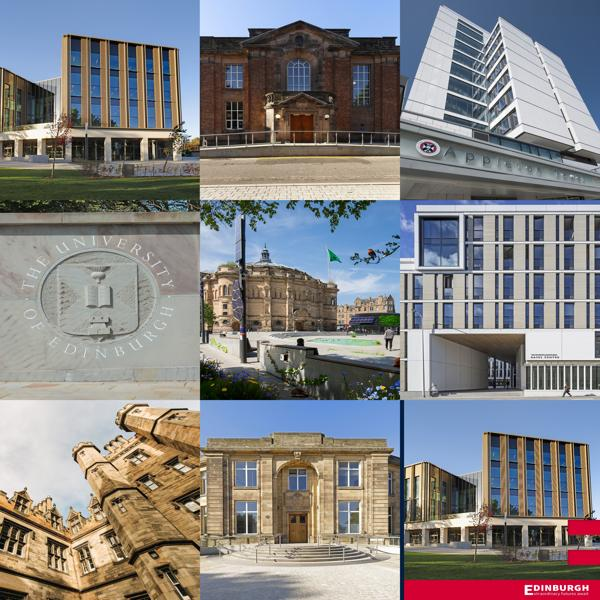
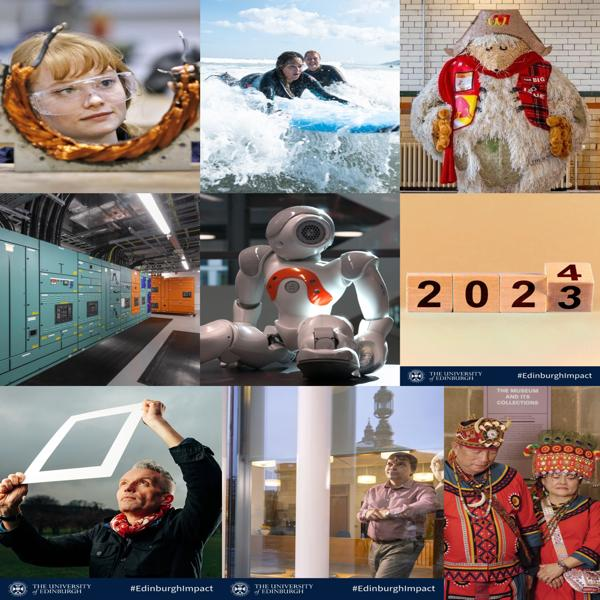
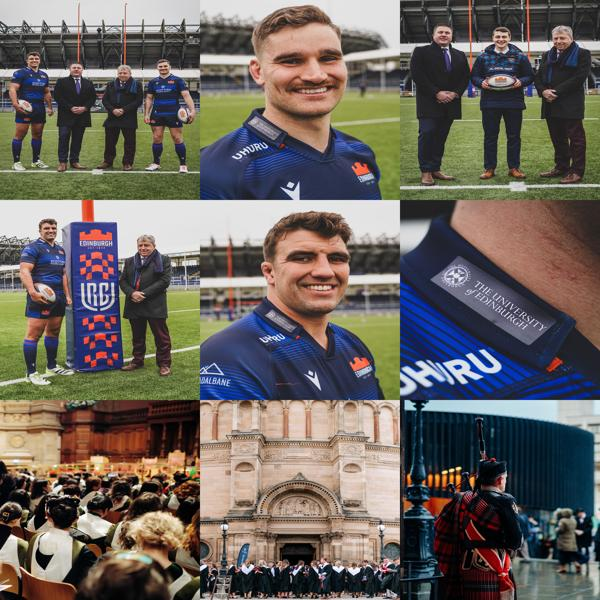

In [14]:
HTML(topic_info.to_html(formatters={'Visual': image_formatter}, escape=False,index=False))

In [ ]:
with open('multimodal.html', 'w') as fo:
    fo.write(topic_info.to_html(formatters={'Visual': image_formatter}, escape=False,index=False))

## Image Only

In [23]:
from bertopic.representation import KeyBERTInspired, VisualRepresentation
from bertopic.backend import MultiModalBackend

# Image embedding model
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Image to text representation model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [24]:
# Train our model with images only
topic_model = BERTopic(embedding_model=embedding_model,
                       representation_model=representation_model,
                       min_topic_size=5,
                       calculate_probabilities=True)
topics, probs = topic_model.fit_transform(documents=None, images=df.image_path.to_list())

  0%|          | 0/10 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [25]:
df['topic'] = topics
probs_df = pd.DataFrame(probs)

In [26]:
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract dataframe
topic_info = topic_model.get_topic_info().drop("Representative_Docs", axis=1).drop("Name", axis=1).drop(index=0)

Topic,Count,Representation,Visual_Aspect
0,48,"[large, building, clock, with, people, on, windows, uniform, train, track]",
1,39,"[dress, is, in, talking, phone, cell, blue, her, black, looking]",
2,22,"[sidewalk, group, standing, sign, posing, for, on, of, woman, people]",
3,21,"[small, pair, person, of, piece, round, scissors, it, on, black]",
4,13,"[walking, street, down, running, soccer, skateboard, ball, women, field, with]",
5,12,"[next, each, other, to, standing, display, sign, woman, table, man]",
6,12,"[tie, and, woman, suit, black, smiling, with, beard, bow, face]",
7,8,"[that, man, sign, holding, the, of, picture, with, reads, says]",
8,6,"[laptop, sitting, at, woman, phone, couch, using, front, cell, girl]",

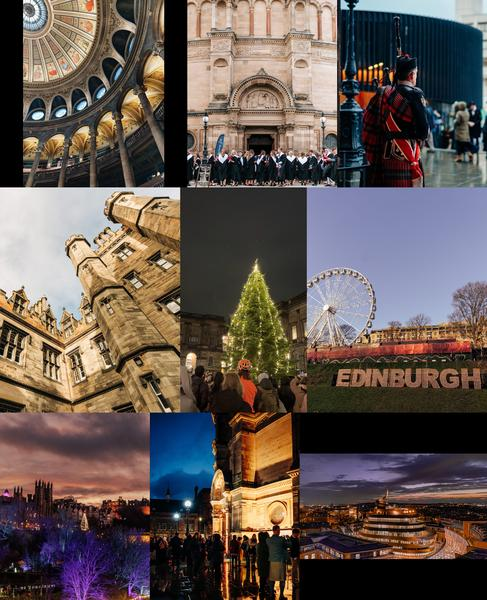
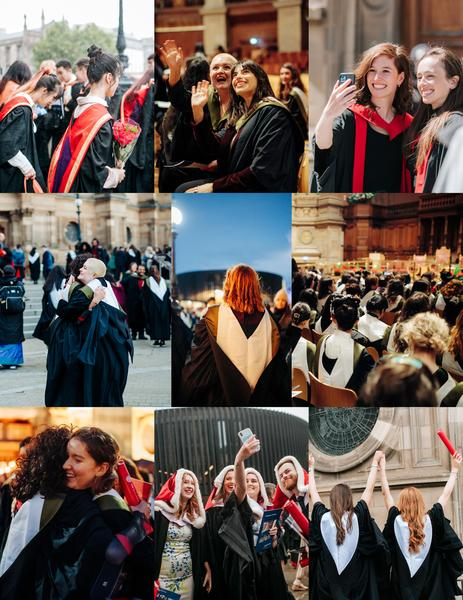
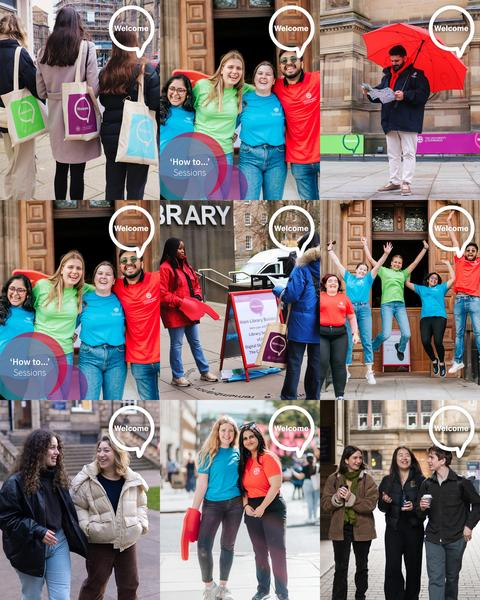
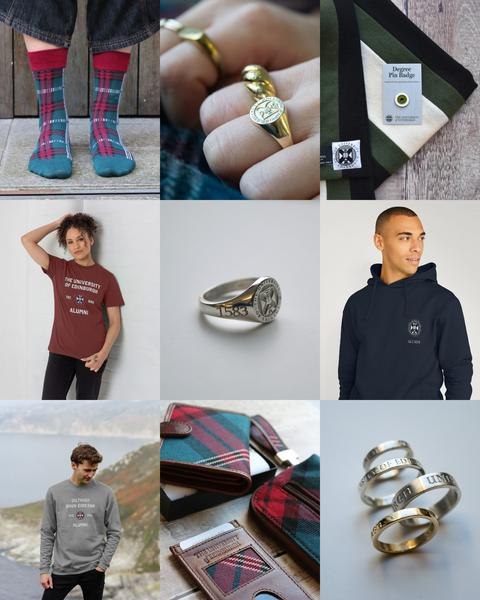
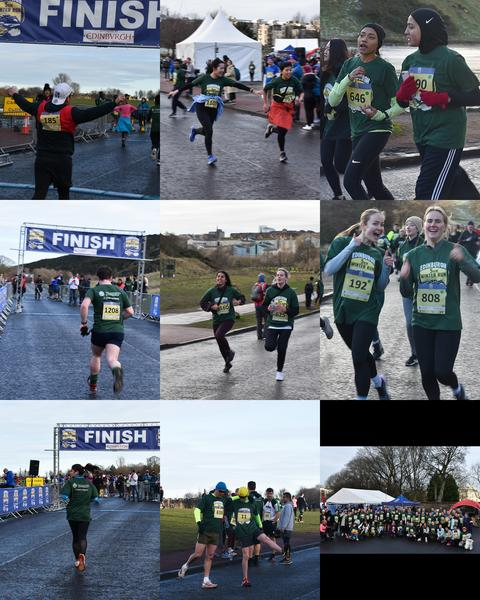
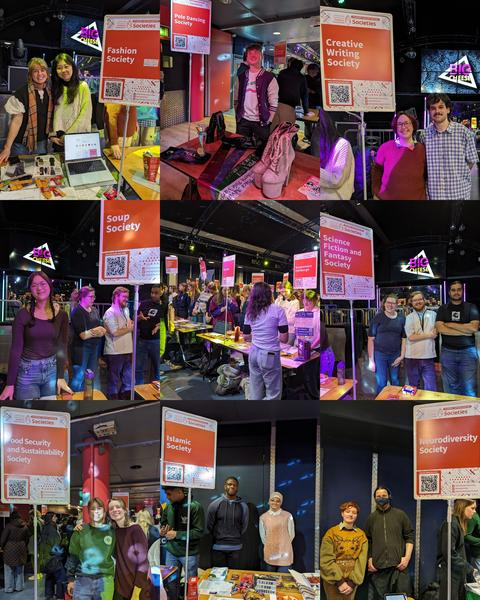
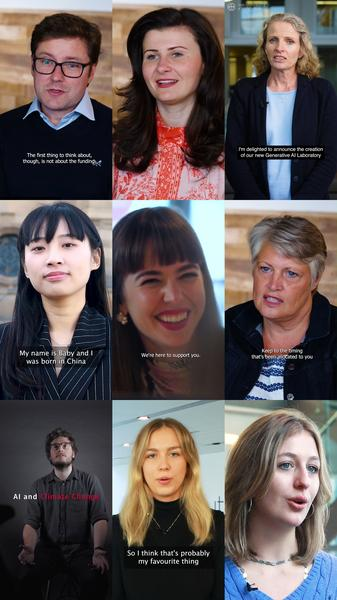
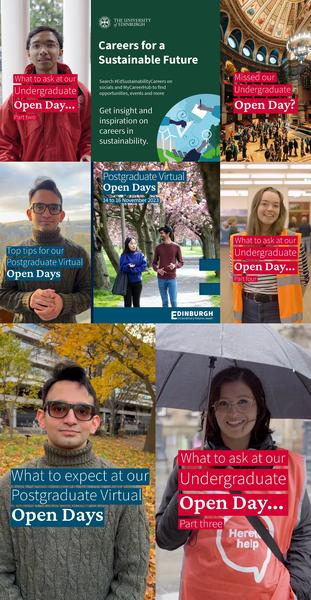
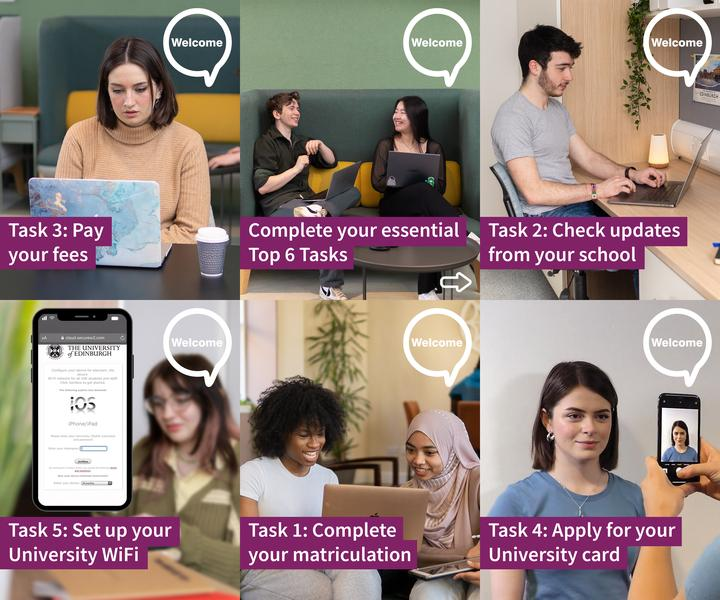

In [28]:
HTML(topic_info.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False,index=False))

In [ ]:
with open('img.html', 'w') as fo:
    fo.write(topic_info.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False, index=False))

## Covert to Text

In [15]:
from transformers import pipeline
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
df['generated_text'] = [image_to_text(x)[0]['generated_text'] for x in df.image_path]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [17]:
docs = df.generated_text + df.text

In [18]:
# Train our model with text only
topic_model = BERTopic(embedding_model=SentenceTransformer("all-MiniLM-L6-v2"),
                       n_gram_range=(1,2),
                       min_topic_size=5,
                       calculate_probabilities=True)
topics, probs = topic_model.fit_transform(documents=docs)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [33]:
df['topic'] = topics
probs_df = pd.DataFrame(probs)

In [34]:
# Extract dataframe
topic_info = topic_model.get_topic_info().drop("Representative_Docs", axis=1).drop("Name", axis=1).drop(index=0)

In [35]:
HTML(topic_info.to_html(escape=False,index=False))

Topic,Count,Representation
0,22,"[the, edinburghgrad, to, winter, in, hashtag, graduations, our, use, and]"
1,16,"[to, our, students, international, and, international students, about, moving, moving to, student]"
2,13,"[graduation, ring, band ring, band, silver, gold, thin, thin band, ring silver, ring gold]"
3,12,"[your, complete, your university, you, up, studies, your studies, fees, start your, to complete]"
4,11,"[alumni, in, sweatshirt in, hoodie, varsity, varsity alumni, hoodie in, sweatshirt, shirt, shirt in]"
5,11,"[taster sessions, taster, sessions, fair, hobby, missed, the taster, giveitagoweek, or, in]"
6,10,"[edinburgh, and, run, dash, winter run, mile, edinburgh winter, students and, loop, and staff]"
7,10,"[welcome, january, welcome week, events, in january, january welcome, week, joining, joining us, in]"
8,10,"[in, ai, we, the, of, that, economic, was, to, what]"
9,9,"[our, to, you, be, so, at, that, guests, check in, attend]"


In [ ]:
with open('text.html', 'w') as fo:
    fo.write(topic_info.to_html(escape=False,index=False))